# AdaBoost

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

**AdaBoost** is a boosting algorithm that try to take a weak classifier on top of one another, **boosting** the overall performance. AdaBoost is extremely simple to use and implement, and often gives very effective results. There is tremendous flexibility in the choice of weak classifier as well. Anyhow, Decision Tree with <code>max_depth=1</code> and <code>max_leaf_nodes=2</code> are often used (also known as **stump**)

<img src = "figures/ada2.png" />

## Hypothesis function

Suppose we are given training data ${(\mathbf{x}^{(i)}, y^{(i)})}$, where $\mathbf{x}^{(i)} \in \mathbb{R}^n$ and $y^{(i)} \in \{-1, 1\}$.  And we have $S$ number of weak classifiers, denoted $h_s(\mathbf{x}^{(i)})$.  For each classifier, we define $\alpha_s$ as the *voting power* of the classifier $h_s(\mathbf{x}^{(i)})$.  Higher the alpha, the more we trust that classifier. Then, the hypothesis function is based on a linear combination of the weak classifier and is written as:

$$
\begin{aligned}
h(\mathbf{x}^{(i)}) & = \text{sign}\big(\alpha_1h_1(\mathbf{x}^{(i)}) + \alpha_2h_2(\mathbf{x}^{(i)}) + \cdots + \alpha_sh_s(\mathbf{x}^{(i)}) )\big) \\
& = \text{sign}\big(\sum_{s=1}^{S}\alpha_sh_s(\mathbf{x}^{(i)})\big)
\end{aligned}
$$

## Define what is a good classifier


Our job is to find the optimal $\alpha_s$, so we can know which classifier we should give more weightage (i.e., believe more).  To get this alpha, we should first define what is "good" classifier.  This is simple, since good classifier should simply has the minimum weighted errors as:

$$\epsilon_s = \frac{\sum_{i=1}^m w_s^{(i)}I(h_s(\mathbf{x}^{(i)}) \neq y^{(i)})}{\sum_{i=1}^m w_s^{(i)}}$$

where

$$\text{range}(\epsilon_s) = [0, 1]$$

in which the weights are initialized in the beginning as

$$w_s^{(i)} = \frac{1}{m}$$ 

where

$$\sum_{i=1}^m w_s^{(i)} = 1$$

For example, given $h(\mathbf{x})$ as <code>yhat</code> and <code>y</code> as the real y, we get:

In [2]:
yhat = np.array([-1,  1, -1, 1, 1]) #(h_s(x))
y    = np.array([ 1,  1,  1, 1, 1])
(yhat != y).sum()

2

We can calculate its weighted errors

In [3]:
m = 5 #since we have five samples

#initially, we set our weight to 1/m
w = np.full(m, 1/m)
print(w)

[0.2 0.2 0.2 0.2 0.2]


In [4]:
e = w[(yhat != y)].sum() / sum(w)
print(e.round(2))

0.4


If we try to change our weight bigger for the first one, you will see that the final error is enlarged.  (Please don't mind why it became 0.7 or 0.05; this is just example.)

In [5]:
w = np.array([0.7, 0.05, 0.05, 0.1, 0.1]) / sum(w)
e = w[(yhat != y)].sum()
print(e.round(2))

0.75


## Updating the weights

Our goal is that once we got the error, we need to emphasize the incorrectly classified sample, so the next classifier will focus on making them right.  Thus we need a weight update rule.  The formula is as follows:

$$w_{s+1}^{(i)} = w_s^{(i)}e^{ -\alpha_sh_s(\mathbf{x^{(i)}}) y^{(i)}}$$

which then need to renormalize 

$$w_{s+1}^{(i)} = \frac{w_{s+1}^{(i)}}{{\displaystyle\sum_{i=1}^m w_{s+1}^{(i)}}} $$

so that

$$\sum_{i=1}^m w_s^{(i)} = 1$$

Here $\alpha_s$ is:

$$\alpha_s = \frac{1}{2}\ln\frac{1-\epsilon_s}{\epsilon_s}$$

where 

$$\text{range}(\alpha_s) = (-\infty, \infty)$$


## Relationship between alpha and errors

Here, higher the error, lower is alpha, which means we don't trust that classifier.  And vice versa.   If e is close to 0 (the classifier performs well), alpha will be positive, indicating that the classifier's predictions should have more influence on the final ensemble. If e is close to 0.5 (the classifier performs worst than random guessing), alpha will be negative, indicating that the classifier's predictions should have less influence, and they will be "flipped" in the ensemble.   Of course, if e is 1, then we should NOT even use this classifier!!

First, to see why this formula works, let's plot alpha against errors:

Text(0, 0.5, 'Alpha')

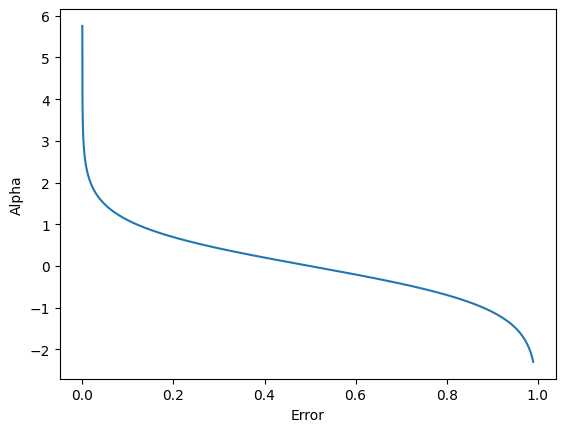

In [6]:
e = np.linspace(0, 0.99, 10000) #select only 0.99 not 1 because np.log(1-1=0) = inf
e = e + 0.00001 #prevent divide by zero
a_j = np.log ((1 - e) / e) * 0.5  #np.log is ln by default

plt.plot(e, a_j)
plt.xlabel("Error")
plt.ylabel("Alpha")

## How this weight update rule works?

$$w_{s+1}^{(i)} = w_s^{(i)}e^{ -\alpha_sh_s(\mathbf{x^{(i)}}) y^{(i)}}$$

Let's first find the alpha.  Recall that:

$$\alpha_s = \frac{1}{2}\ln\frac{1-\epsilon_s}{\epsilon_s}$$

where

$$\epsilon_s = \frac{\sum_{i=1}^m w_s^{(i)}I(h_s(\mathbf{x}^{(i)}) \neq y^{(i)})}{\sum_{i=1}^m w_s^{(i)}}$$

In [7]:
#recall the y and yhat
print(y, yhat)

[1 1 1 1 1] [-1  1 -1  1  1]


In [8]:
#recall the error
w = np.full(m, 1/m)
e = w[(yhat != y)].sum() / sum(w)
print(e)

0.4


In [9]:
#calculate the a_j
a_j = np.log ((1 - e) / e) * 0.5
print(a_j)

0.2027325540540821


After we find the initial alpha, let's plug everthing into the weight update rule, starting from this component:

$$h_s(\mathbf{x^{(i)}}) y^{(i)} $$

In [10]:
yhat * y

array([-1,  1, -1,  1,  1])

Try to understand what multiplying actually means.  Notice that negative means the answer is wrong.

We multiply negative alpha so that incorrectly classified sample will have bigger value.

Why do we need to make the incorrectly classified sample have bigger value?  Well, because we want incorrectly classified sample to have bigger weight so the next classifier can focus on it.

$$-\alpha_sh_s(\mathbf{x^{(i)}}) y^{(i)} $$

In [11]:
-a_j * yhat * y 

array([ 0.20273255, -0.20273255,  0.20273255, -0.20273255, -0.20273255])

Next, since we will multiply this with the weight, we perform exp to make sure that the resulting number is positive.

$$e^{ -\alpha_sh_s(\mathbf{x^{(i)}}) y^{(i)}} $$

In [12]:
np.exp(-a_j * yhat * y)  

#we perform np.exp to keep them positive number because weight cannot be negative

array([1.22474487, 0.81649658, 1.22474487, 0.81649658, 0.81649658])

Last, we calculate everything.

$$w_{s+1}^{(i)} = w_s^{(i)}e^{ -\alpha_sh_s(\mathbf{x^{(i)}}) y^{(i)}}$$

which then need to renormalize 

$$w_{s+1}^{(i)} = \frac{w_{s+1}^{(i)}}{{\displaystyle\sum_{i=1}^m w_{s+1}^{(i)}}} $$

In [13]:
w = w * np.exp(-a_j * yhat * y)
w

array([0.24494897, 0.16329932, 0.24494897, 0.16329932, 0.16329932])

In [14]:
#normalize
w = w / sum(w)  
w

array([0.25      , 0.16666667, 0.25      , 0.16666667, 0.16666667])

**So what does this number means?**

Well, notice that the incorrectly classified samples are #1 and #3, and they both have bigger weights than others.   This will make sure next classifier will focus on solving it.

## Negative alpha?

Notice that when alpha is negative, wrongly classified samples do not get bigger weights.  Why?

In short, by assigning negative alpha values, the algorithm effectively flips the predictions of the weak classifier, so their combined effect is closer to random guessing, reducing their influence on the final strong classifier.

In some cases, we should just throw all classifiers having negative alpha.

## Putting everything together

1. Create your first classifier (e.g., `DecisionTrees`) and fit the training set.

2. Calculate the error of the first classifier

$$\epsilon_s = \frac{\sum_{i=1}^m w_s^{(i)}I(h_s(\mathbf{x}^{(i)}) \neq y^{(i)})}{\sum_{i=1}^m w_s^{(i)}}$$

3. Calculate alpha of the first classifier

$$\alpha_s = \frac{1}{2}ln\frac{1-\epsilon_s}{\epsilon_s}$$

4. Exaggerate the incorrect samples using

$$w_{s+1}^{(i)} = w_s^{(i)}e^{ -\alpha_sh_s(\mathbf{x^{(i)}}) y^{(i)}}$$

which then renormalize 

$$w_{s+1}^{(i)} = \frac{w_{s+1}^{(i)}}{{\displaystyle\sum_{i=1}^m w_{s+1}^{(i)}}} $$

5. Repeat 1.

6. We stop 1-4 using early stopping, reached number of classifiers, or certain error threshold is reached.

7. To predict, we use the hypothesis function:

$$ 
  h(\mathbf{x}) = \text{sign}\big(\sum_{s=1}^{S}\alpha_sh_s(\mathbf{x})\big)
$$

## 1. Scratch

In [15]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, random_state=1)
y = np.where(y==0,-1,1)  #change our y to be -1 if it is 0, otherwise 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

m = X_train.shape[0]
S = 20
stump_params = {'max_depth': 1, 'max_leaf_nodes': 2}
models = [DecisionTreeClassifier(**stump_params) for _ in range(S)]

#initially, we set our weight to 1/m
w = np.full(m, 1/m)

#keep collection of a_j
a_js = np.zeros(S)

for j, model in enumerate(models):
    
    #train weak learner
    model.fit(X_train, y_train, sample_weight = w)
    
    #compute the errors
    yhat = model.predict(X_train) 
    
    e = w[(yhat != y_train)].sum() / sum(w)
    
    # print(f"e_{j}: {e}")
        
    #compute the predictor weight a_j
    #if predictor is doing well, a_j will be big
    a_j = np.log ((1 - e) / e) / 2
    a_js[j] = a_j
    
    print(f"a_{j}: {a_j}")
    
    #update sample weight; divide sum of W to normalize
    w = (w * np.exp(-a_j * y_train * yhat))
    w = w / sum(w)    
    
    # print(sum(w))  #make sure always sum to 1

        
#make weighted predictions
h = 0
for i, model in enumerate(models):
    yhat = model.predict(X_test)
    h += a_js[i] * yhat
    
yhat = np.sign(h)

print(classification_report(y_test, yhat))

a_0: 1.4573816055101643
a_1: 0.4861280111506205
a_2: 0.2585364906779028
a_3: 0.5638365346080928
a_4: 0.47162902784400756
a_5: 0.28504868984885795
a_6: 0.23151576673325486
a_7: 0.3518645068326187
a_8: 0.3605190018519204
a_9: 0.3147970623243156
a_10: 0.3702580922616173
a_11: 0.38906768724141066
a_12: 0.38029109425895147
a_13: 0.30624491550448657
a_14: 0.4736826102203567
a_15: 0.38344932944148
a_16: 0.3951664184073484
a_17: 0.4072703833775688
a_18: 0.2930361975822689
a_19: 0.40154165674893993
              precision    recall  f1-score   support

          -1       0.96      0.97      0.97        79
           1       0.97      0.96      0.96        71

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



## 2. Sklearn 

The following code trains an AdaBoost classifier based on 200 Decision stumps.  A Decision stump is basically a Decision Tree with max_depth=1.  This is the default base estimator of AdaBoostClassifier class:

In [17]:
from sklearn.ensemble import AdaBoostClassifier

#SAMME.R - a variant of SAMME which relies on class probabilities 
#rather than predictions and generally performs better
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print("Ada score: ", accuracy_score(y_test, y_pred))

Ada score:  0.9666666666666667


## Group workshop

Given `yhat = [-1, 1, -1, 1, 1]` and `y = [1, 1, 1, 1, 1]`:

1. Calculate the weights of each sample using 

$$w_s^{(i)} = \frac{1}{m}$$

2. What does $s$ here mean? What does these weights even mean?  
3. What is the sum of all weights?  What is the range of each weight?
4. Calculate its weighted error using

$$\epsilon_s = \frac{\sum_{i=1}^m w_s^{(i)}I(h_s(\mathbf{x}^{(i)}) \neq y^{(i)})}{\sum_{i=1}^m w_s^{(i)}}$$

5. Okay, we got a number called $\epsilon$.  What this $\epsilon$ means??
6. Calculate alpha using 

$$\alpha_s = \frac{1}{2}\ln\frac{1-\epsilon_s}{\epsilon_s}$$

7. Okay, we got a number called $\alpha$.  What this $\alpha$ means?  Higher means what? Lower?
8. Calculate 

$$e^{ -\alpha_sh_s(\mathbf{x^{(i)}}) y^{(i)}} $$

9. What does these numbers mean?  
10. Finally, calculate 

$$w_{s+1}^{(i)} = w_s^{(i)}e^{ -\alpha_sh_s(\mathbf{x^{(i)}}) y^{(i)}}$$

which then renormalize 

$$w_{s+1}^{(i)} = \frac{w_{s+1}^{(i)}}{{\displaystyle\sum_{i=1}^m w_{s+1}^{(i)}}} $$

11. We got some new weights.  What these new weights trying to achieve?
    
12. So in AdaBoost, when do we stop?  List three ways.
    
13. Take a look at `Extended - AdaBoost.ipynb` for additional details - if you are interested.